# Evaluate DistilBERT on Independent Sets

## 1 Import libraries

Import libraries for data loading, Hugging Face Transformers (for loading the saved model/tokenizer), PyTorch, and evaluation metrics.

In [2]:
print("Loading libraries..")

# Core libraries
import os
import pandas as pd
import numpy as np
import time
import zipfile
import shutil

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Scikit-learn libraries
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)

# Downloading from Google Drive
import gdown

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("WARNING: GPU not available, using CPU. Evaluation might be slower.")

pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', 50)

print("Libraries imported.")

Loading libraries..
Using GPU: Tesla T4
Libraries imported.


## 2 Load fine-tuned DistilBERT Model and Tokenizer

In [3]:
# --- Define GDrive ID and Local Filenames for the ZIPPED Model Directory ---
GDRIVE_MODEL_DIR_ZIP_ID = '1tIyuHVNjt2g8K3aP0uqw39cijSX_55cl'
LOCAL_MODEL_DIR_ZIP_FILENAME = 'phishing-distilbert.zip'

# Path where the model directory will be after unzipping
DISTILBERT_MODEL_LOAD_PATH = './phishing-distilbert/'

# --- gdown download function ---
def download_file_from_gdrive(file_id, local_filename):
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename} from Google Drive...")
        gdrive_url = f'https://drive.google.com/uc?id={file_id}'

        try:
            gdown.download(gdrive_url, local_filename, quiet=False)
            print(f"{local_filename} downloaded successfully.")

        except Exception as e:
            print(f"ERROR downloading {local_filename}: {e}. Check File ID and share settings.")
            return False
    else:
        print(f"{local_filename} already exists in Colab runtime.")

    return os.path.exists(local_filename)

# --- Download and Unzip the Model Directory ---
loaded_distilbert_model = None
loaded_tokenizer = None
model_components_loaded_distilbert = False

# Check if the target directory already exists (e.g., from a previous run)
if os.path.exists(DISTILBERT_MODEL_LOAD_PATH) and os.listdir(DISTILBERT_MODEL_LOAD_PATH):
    print(f"Model directory '{DISTILBERT_MODEL_LOAD_PATH}' already exists and is not empty. Attempting to load directly.")

    # Assume it's ready for loading
    model_components_loaded_distilbert = True

elif download_file_from_gdrive(GDRIVE_MODEL_DIR_ZIP_ID, LOCAL_MODEL_DIR_ZIP_FILENAME):
    if os.path.exists(LOCAL_MODEL_DIR_ZIP_FILENAME):
        print(f"Unzipping {LOCAL_MODEL_DIR_ZIP_FILENAME} to recreate '{DISTILBERT_MODEL_LOAD_PATH}'...")
        try:
            if os.path.exists(DISTILBERT_MODEL_LOAD_PATH): # Clean up if dir exists but was empty
                shutil.rmtree(DISTILBERT_MODEL_LOAD_PATH)

            with zipfile.ZipFile(LOCAL_MODEL_DIR_ZIP_FILENAME, 'r') as zip_ref:
                # Extracts to current directory, assuming zip contains the folder
                zip_ref.extractall('./')

            print(f"Successfully unzipped to create/populate '{DISTILBERT_MODEL_LOAD_PATH}'.")

            # Ready for loading attempt
            model_components_loaded_distilbert = True

        except Exception as e:
            print(f"Error unzipping {LOCAL_MODEL_DIR_ZIP_FILENAME}: {e}")
            model_components_loaded_distilbert = False

    else:
        print(f"Zip file {LOCAL_MODEL_DIR_ZIP_FILENAME} not found after download attempt.")
        model_components_loaded_distilbert = False

else:
    print(f"Could not download the model zip file.")
    model_components_loaded_distilbert = False


# --- Load Model and Tokenizer from the (now local) directory ---
if model_components_loaded_distilbert and os.path.exists(DISTILBERT_MODEL_LOAD_PATH) and os.path.isdir(DISTILBERT_MODEL_LOAD_PATH):
    try:
        print(f"\nLoading fine-tuned DistilBERT model from local path: {DISTILBERT_MODEL_LOAD_PATH}")
        loaded_distilbert_model = DistilBertForSequenceClassification.from_pretrained(DISTILBERT_MODEL_LOAD_PATH)

        # Move model to GPU
        loaded_distilbert_model.to(device)

        # Set to evaluation mode
        loaded_distilbert_model.eval()

        print(f"Loading tokenizer from local path: {DISTILBERT_MODEL_LOAD_PATH}")
        loaded_tokenizer = DistilBertTokenizerFast.from_pretrained(DISTILBERT_MODEL_LOAD_PATH)

        print("DistilBERT model and tokenizer loaded successfully.")

    except Exception as e:
        print(f"Error loading DistilBERT model or tokenizer from {DISTILBERT_MODEL_LOAD_PATH}: {e}")
        model_components_loaded_distilbert = False

# True from download/unzip but path check failed
elif model_components_loaded_distilbert:
    print(f"ERROR: Path '{DISTILBERT_MODEL_LOAD_PATH}' not found or not a directory after unzip attempt.")
    model_components_loaded_distilbert = False

if not model_components_loaded_distilbert:
    print("\nCritical error: DistilBERT model or tokenizer could not be loaded. Cannot proceed with evaluation.")

Downloading...
From (original): https://drive.google.com/uc?id=1tIyuHVNjt2g8K3aP0uqw39cijSX_55cl
From (redirected): https://drive.google.com/uc?id=1tIyuHVNjt2g8K3aP0uqw39cijSX_55cl&confirm=t&uuid=551116b6-f51b-4498-b969-45a2c40f091d
To: /content/phishing-distilbert.zip
100%|██████████| 247M/247M [00:04<00:00, 51.1MB/s]


phishing-distilbert.zip downloaded successfully.
Unzipping phishing-distilbert.zip to recreate './phishing-distilbert/'...
Successfully unzipped to create/populate './phishing-distilbert/'.

Loading fine-tuned DistilBERT model from local path: ./phishing-distilbert/
Loading tokenizer from local path: ./phishing-distilbert/
DistilBERT model and tokenizer loaded successfully.


## 3 Define Helper Functions

- A PyTorch Dataset class for inference (to handle tokenization and batching of the independent test sets).
- An evaluation function to make predictions with the loaded DistilBERT model and calculate metrics for each test set.

In [4]:
class InferenceTextDataset(Dataset):
    def __init__(self, texts_list, tokenizer_instance, max_seq_len, labels_list=None):
        self.texts = texts_list
        self.tokenizer = tokenizer_instance
        self.max_len = max_seq_len

        # Labels are crucial for evaluation
        self.labels = labels_list

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):

        # Ensure text is string
        text_item = str(self.texts[idx])

        encoding = self.tokenizer.encode_plus(
            text_item,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', # Pad to max_length
            truncation=True,      # Truncate to max_length
            return_attention_mask=True,
            return_tensors='pt',  # Return PyTorch tensors
        )

        item_data = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            item_data['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item_data

def evaluate_distilbert_on_test_df(df_to_eval, text_col_name, label_col_name, dataset_name_str, model, tokenizer_instance, batch_size=16):
    print(f"\n--- Evaluating DistilBERT on: {dataset_name_str} ---")

    if model is None or tokenizer_instance is None:
        print(f"Model or tokenizer not loaded. Skipping evaluation for {dataset_name_str}.")
        return None

    if df_to_eval.empty or text_col_name not in df_to_eval.columns or label_col_name not in df_to_eval.columns:
        print(f"DataFrame for {dataset_name_str} is empty or missing required columns ('{text_col_name}', '{label_col_name}'). Skipping.")
        return None

    eval_texts_list = df_to_eval[text_col_name].fillna('').tolist()
    eval_true_labels_list = df_to_eval[label_col_name].astype(int).tolist()

    # Use a practical max length
    max_len_eval = min(tokenizer_instance.model_max_length, 256)

    eval_pytorch_dataset = InferenceTextDataset(eval_texts_list, tokenizer_instance, max_len_eval, labels_list=eval_true_labels_list)

    # Use specified batch_size
    eval_pytorch_loader = DataLoader(eval_pytorch_dataset, batch_size=batch_size)

    model.eval()
    all_predictions = []
    all_true_labels_from_loader = []
    all_probabilities_positive_class = []

    with torch.no_grad():
        for batch_data in eval_pytorch_loader:
            input_ids_batch = batch_data['input_ids'].to(device)
            attention_mask_batch = batch_data['attention_mask'].to(device)
            labels_batch = batch_data['labels'].to(device)

            outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
            logits = outputs.logits

            probabilities = torch.softmax(logits, dim=-1)
            predictions = torch.argmax(logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels_from_loader.extend(labels_batch.cpu().numpy())
            all_probabilities_positive_class.extend(probabilities[:, 1].cpu().numpy())

    acc = accuracy_score(all_true_labels_from_loader, all_predictions)
    prec = precision_score(all_true_labels_from_loader, all_predictions, zero_division=0)
    rec = recall_score(all_true_labels_from_loader, all_predictions, zero_division=0)
    f1 = f1_score(all_true_labels_from_loader, all_predictions, zero_division=0)
    try: roc_auc = roc_auc_score(all_true_labels_from_loader, all_probabilities_positive_class)
    except ValueError: roc_auc = float('nan'); print("Warning: ROC AUC for DistilBERT could not be computed.")

    print(f"\nResults for {dataset_name_str}:")
    print(f"  Accuracy:  {acc:.4f}"); print(f"  Precision (Phishing): {prec:.4f}"); print(f"  Recall (Phishing):    {rec:.4f}"); print(f"  F1-score (Phishing):  {f1:.4f}"); print(f"  ROC AUC:   {roc_auc:.4f}")
    print("\n  Classification Report:"); print(classification_report(all_true_labels_from_loader, all_predictions, zero_division=0, target_names=['Ham (0)', 'Phish (1)']))

    cm = confusion_matrix(all_true_labels_from_loader, all_predictions, labels=[0,1])
    plt.figure(figsize=(5,3)); sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Pred Ham (0)', 'Pred Phish (1)'], yticklabels=['True Ham (0)', 'True Phish (1)'])
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title(f'Confusion Matrix - {dataset_name_str}'); plt.show()

    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'ROC_AUC': roc_auc}

print("Helper functions defined.")

Helper functions defined.


## 4 Load and Evaluate on Independent Test Sets


--- Processing Test Set for DistilBERT: SpamAssassin Easy Ham (DistilBERT) ---


Downloading...
From: https://drive.google.com/uc?id=1Red18eXIOPbEuQfRnzt8WvgdsfYdrGH2
To: /content/spamassassin_easy_ham_test_2500.csv
100%|██████████| 3.77M/3.77M [00:00<00:00, 27.4MB/s]


spamassassin_easy_ham_test_2500.csv downloaded successfully.

--- Evaluating DistilBERT on: SpamAssassin Easy Ham (DistilBERT) ---

Results for SpamAssassin Easy Ham (DistilBERT):
  Accuracy:  0.9584
  Precision (Phishing): 0.0000
  Recall (Phishing):    0.0000
  F1-score (Phishing):  0.0000
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

     Ham (0)       1.00      0.96      0.98      2500
   Phish (1)       0.00      0.00      0.00         0

    accuracy                           0.96      2500
   macro avg       0.50      0.48      0.49      2500
weighted avg       1.00      0.96      0.98      2500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


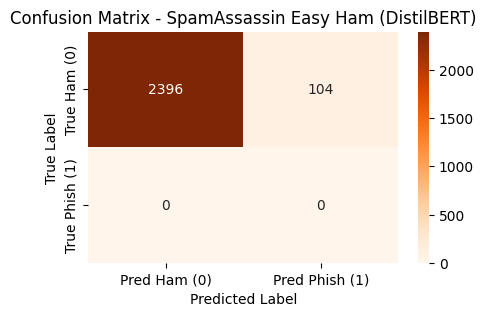


--- Processing Test Set for DistilBERT: SpamAssassin Hard Ham (DistilBERT) ---


Downloading...
From: https://drive.google.com/uc?id=1yM_Ab-RkksL2tEe9Z88aRFh4Y_9FURoc
To: /content/spamassassin_hard_ham_test_250.csv
100%|██████████| 1.85M/1.85M [00:00<00:00, 16.3MB/s]


spamassassin_hard_ham_test_250.csv downloaded successfully.

--- Evaluating DistilBERT on: SpamAssassin Hard Ham (DistilBERT) ---

Results for SpamAssassin Hard Ham (DistilBERT):
  Accuracy:  0.9880
  Precision (Phishing): 0.0000
  Recall (Phishing):    0.0000
  F1-score (Phishing):  0.0000
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

     Ham (0)       1.00      0.99      0.99       250
   Phish (1)       0.00      0.00      0.00         0

    accuracy                           0.99       250
   macro avg       0.50      0.49      0.50       250
weighted avg       1.00      0.99      0.99       250



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


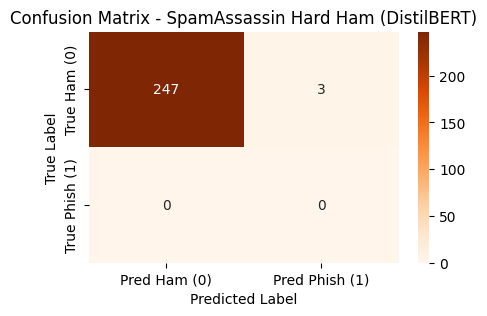


--- Processing Test Set for DistilBERT: Nigerian Fraud Test (DistilBERT) ---


Downloading...
From: https://drive.google.com/uc?id=1nBk5-BGtr7uNSctwNowmy8QWwv9XEt7-
To: /content/nigerian_fraud_test_processed_3978.csv
100%|██████████| 11.0M/11.0M [00:00<00:00, 34.3MB/s]


nigerian_fraud_test_processed_3978.csv downloaded successfully.

--- Evaluating DistilBERT on: Nigerian Fraud Test (DistilBERT) ---

Results for Nigerian Fraud Test (DistilBERT):
  Accuracy:  0.3175
  Precision (Phishing): 1.0000
  Recall (Phishing):    0.3175
  F1-score (Phishing):  0.4820
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00         0
   Phish (1)       1.00      0.32      0.48      3978

    accuracy                           0.32      3978
   macro avg       0.50      0.16      0.24      3978
weighted avg       1.00      0.32      0.48      3978



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


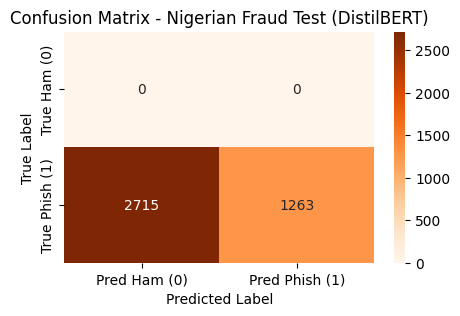


--- Processing Test Set for DistilBERT: Nazario Phishing Test (DistilBERT) ---


Downloading...
From: https://drive.google.com/uc?id=1RDIiMFLfz9YOvw1M6lYmOzmJSILJaQ7d
To: /content/nazario_phishing_test_processed_1561.csv
100%|██████████| 6.18M/6.18M [00:00<00:00, 28.6MB/s]


nazario_phishing_test_processed_1561.csv downloaded successfully.

--- Evaluating DistilBERT on: Nazario Phishing Test (DistilBERT) ---

Results for Nazario Phishing Test (DistilBERT):
  Accuracy:  0.3773
  Precision (Phishing): 1.0000
  Recall (Phishing):    0.3773
  F1-score (Phishing):  0.5479
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00         0
   Phish (1)       1.00      0.38      0.55      1561

    accuracy                           0.38      1561
   macro avg       0.50      0.19      0.27      1561
weighted avg       1.00      0.38      0.55      1561



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


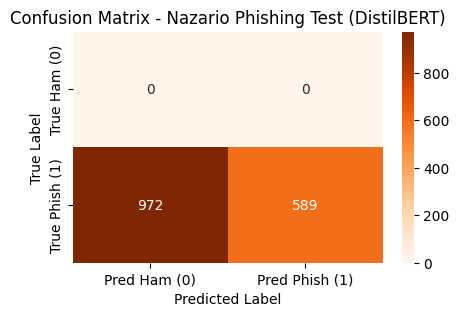


--- Processing Test Set for DistilBERT: SpamAssassin Spam/Phish Test (DistilBERT) ---


Downloading...
From: https://drive.google.com/uc?id=16jkyCOQ1IBdcZjoJv8XeUz6IAM7UmrRM
To: /content/spamassassin_phishing_for_training_1896.csv
100%|██████████| 4.46M/4.46M [00:00<00:00, 28.2MB/s]


spamassassin_phishing_for_training_1896.csv downloaded successfully.

--- Evaluating DistilBERT on: SpamAssassin Spam/Phish Test (DistilBERT) ---

Results for SpamAssassin Spam/Phish Test (DistilBERT):
  Accuracy:  0.2827
  Precision (Phishing): 1.0000
  Recall (Phishing):    0.2827
  F1-score (Phishing):  0.4408
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00         0
   Phish (1)       1.00      0.28      0.44      1896

    accuracy                           0.28      1896
   macro avg       0.50      0.14      0.22      1896
weighted avg       1.00      0.28      0.44      1896



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


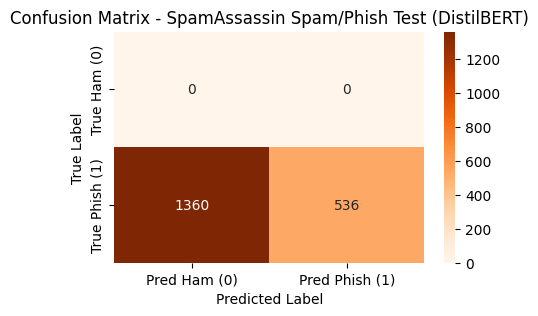



--- Summary of DistilBERT Evaluations on Independent Test Sets ---

Dataset: SpamAssassin Easy Ham (DistilBERT)
  Accuracy: 0.9584
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC_AUC: nan

Dataset: SpamAssassin Hard Ham (DistilBERT)
  Accuracy: 0.9880
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC_AUC: nan

Dataset: Nigerian Fraud Test (DistilBERT)
  Accuracy: 0.3175
  Precision: 1.0000
  Recall: 0.3175
  F1-Score: 0.4820
  ROC_AUC: nan

Dataset: Nazario Phishing Test (DistilBERT)
  Accuracy: 0.3773
  Precision: 1.0000
  Recall: 0.3773
  F1-Score: 0.5479
  ROC_AUC: nan

Dataset: SpamAssassin Spam/Phish Test (DistilBERT)
  Accuracy: 0.2827
  Precision: 1.0000
  Recall: 0.2827
  F1-Score: 0.4408
  ROC_AUC: nan


In [5]:
# --- Define GDrive IDs and Local Filenames for your processed Independent Test Sets ---
SA_EASY_HAM_GDRIVE_ID = '1Red18eXIOPbEuQfRnzt8WvgdsfYdrGH2'
SA_EASY_HAM_LOCAL = 'spamassassin_easy_ham_test_2500.csv'

SA_HARD_HAM_GDRIVE_ID = '1yM_Ab-RkksL2tEe9Z88aRFh4Y_9FURoc'
SA_HARD_HAM_LOCAL = 'spamassassin_hard_ham_test_250.csv'

NIGERIAN_FRAUD_GDRIVE_ID = '1nBk5-BGtr7uNSctwNowmy8QWwv9XEt7-'
NIGERIAN_FRAUD_LOCAL = 'nigerian_fraud_test_processed_3978.csv'

NAZARIO_PHISH_GDRIVE_ID = '1RDIiMFLfz9YOvw1M6lYmOzmJSILJaQ7d'
NAZARIO_PHISH_LOCAL = 'nazario_phishing_test_processed_1561.csv'

SA_SPAM_TEST_GDRIVE_ID = '16jkyCOQ1IBdcZjoJv8XeUz6IAM7UmrRM'
SA_SPAM_TEST_LOCAL = 'spamassassin_phishing_for_training_1896.csv'

# List of test datasets to evaluate
# Each entry: (gdrive_id, local_filename, dataset_name, text_col_name, label_col_name)
independent_test_sets_info_distilbert = [
    {
        'gdrive_id': SA_EASY_HAM_GDRIVE_ID,
        'local_filename': SA_EASY_HAM_LOCAL,
        'dataset_name': "SpamAssassin Easy Ham (DistilBERT)",
        'text_col': 'body_cleaned',
        'label_col': 'label'
    },
    {
        'gdrive_id': SA_HARD_HAM_GDRIVE_ID,
        'local_filename': SA_HARD_HAM_LOCAL,
        'dataset_name': "SpamAssassin Hard Ham (DistilBERT)",
        'text_col': 'body_cleaned',
        'label_col': 'label'
    },
    {
        'gdrive_id': NIGERIAN_FRAUD_GDRIVE_ID,
        'local_filename': NIGERIAN_FRAUD_LOCAL,
        'dataset_name': "Nigerian Fraud Test (DistilBERT)",
        'text_col': 'body_cleaned_minimal',
        'label_col': 'label'
    },
    {
        'gdrive_id': NAZARIO_PHISH_GDRIVE_ID,
        'local_filename': NAZARIO_PHISH_LOCAL,
        'dataset_name': "Nazario Phishing Test (DistilBERT)",
        'text_col': 'body_cleaned',
        'label_col': 'label'
    },
    {
        'gdrive_id': SA_SPAM_TEST_GDRIVE_ID,
        'local_filename': SA_SPAM_TEST_LOCAL,
        'dataset_name': "SpamAssassin Spam/Phish Test (DistilBERT)",
        'text_col': 'body_cleaned',
        'label_col': 'label'
    }
]

all_independent_results_distilbert = {}

def download_file_from_gdrive(file_id, local_filename):
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename} from Google Drive...")
        gdrive_url = f'https://drive.google.com/uc?id={file_id}'

        try:
          gdown.download(gdrive_url, local_filename, quiet=False);
          print(f"{local_filename} downloaded successfully.")

        except Exception as e:
          print(f"ERROR downloading {local_filename}: {e}")
          return False

    else:
      print(f"{local_filename} already exists in Colab runtime.")

    return os.path.exists(local_filename)


if not model_components_loaded_distilbert:
    print("DistilBERT Model or Tokenizer not loaded. Cannot perform evaluations.")
else:
    for test_set_info in independent_test_sets_info_distilbert:
        gdrive_id = test_set_info['gdrive_id']
        local_fname = test_set_info['local_filename']
        ds_name = test_set_info['dataset_name']
        text_c = test_set_info['text_col']
        label_c = test_set_info['label_col']

        print(f"\n--- Processing Test Set for DistilBERT: {ds_name} ---")
        if download_file_from_gdrive(gdrive_id, local_fname):
            try:
                df_current_test_set = pd.read_csv(local_fname)

                if not df_current_test_set.empty:
                    results = evaluate_distilbert_on_test_df(
                        df_current_test_set,
                        text_c,
                        label_c,
                        ds_name,
                        loaded_distilbert_model,
                        loaded_tokenizer
                    )

                    if results:
                        all_independent_results_distilbert[ds_name] = results

                else:
                    print(f"DataFrame for {ds_name} is empty after loading from {local_fname}.")

            except Exception as e:
                print(f"Error processing or evaluating {ds_name} from {local_fname}: {e}")

        else:
            print(f"Could not download/access {local_fname} for {ds_name}. Skipping evaluation.")

print("\n\n--- Summary of DistilBERT Evaluations on Independent Test Sets ---")
if all_independent_results_distilbert:

    for ds_name, metrics in all_independent_results_distilbert.items():
        print(f"\nDataset: {ds_name}")

        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")

else:
    print("No results from DistilBERT independent test set evaluations.")